In [100]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [146]:
# Minimal preprocessing
base = pd.read_csv("base_ML_dataset.csv")
metadata = base.iloc[:, -2:]
metadata = metadata.reset_index().rename(columns = {"index": "assay_id"})
metadata.loc[metadata.tissue_type == "T-cell", "tissue_type"] = "blood"
labels = base.pop("tissue_type")
data = base.iloc[:, :-1]
data.fillna(0, inplace = True)
data.head()

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.000010,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000070,0.000016,0.000028,0.000040,0.000062,0.000000,0.000088,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000068,0.000016,0.000033,0.000042,0.000045,0.000001,0.000075,0.000000,0.0,0.0
2,0.000011,0.0,0.000061,0.0,0.0,0.000016,0.0,0.000002,0.0,0.0,...,0.000000,0.000000,0.000007,0.000024,0.000045,0.000000,0.000092,0.000024,0.0,0.0
3,0.000011,0.0,0.000080,0.0,0.0,0.000016,0.0,0.000002,0.0,0.0,...,0.000000,0.000000,0.000005,0.000035,0.000033,0.000000,0.000076,0.000024,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000350,0.000000,0.0,0.0


In [147]:
print(labels.value_counts().values)
total = sum(labels.value_counts().values)
print(labels.value_counts().index.values)

[83 74 63 49 48 47 28 26 26 20 18 11  4  4  4  4  1]
['breast' 'blood' 'brain' 'ovary' '/' 'cervix' 'umbilical vein' 'colon'
 'skin' 'kidney' 'trophoblast' 'liver' 'prostate' 'fetal kidney'
 'fibroblast' 'lung' 'T-cell']


In [142]:
labels.value_counts()/total *100

breast            16.274510
blood             14.705882
brain             12.352941
ovary              9.607843
cervix             9.215686
umbilical vein     5.490196
colon              5.098039
skin               5.098039
kidney             3.921569
liver              2.156863
Name: tissue_type, dtype: float64

In [134]:
labels.value_counts()

breast            83
blood             75
brain             63
ovary             49
cervix            47
umbilical vein    28
colon             26
skin              26
kidney            20
liver             11
Name: tissue_type, dtype: int64

In [137]:
labels.value_counts().values

array([83, 75, 63, 49, 47, 28, 26, 26, 20, 11])

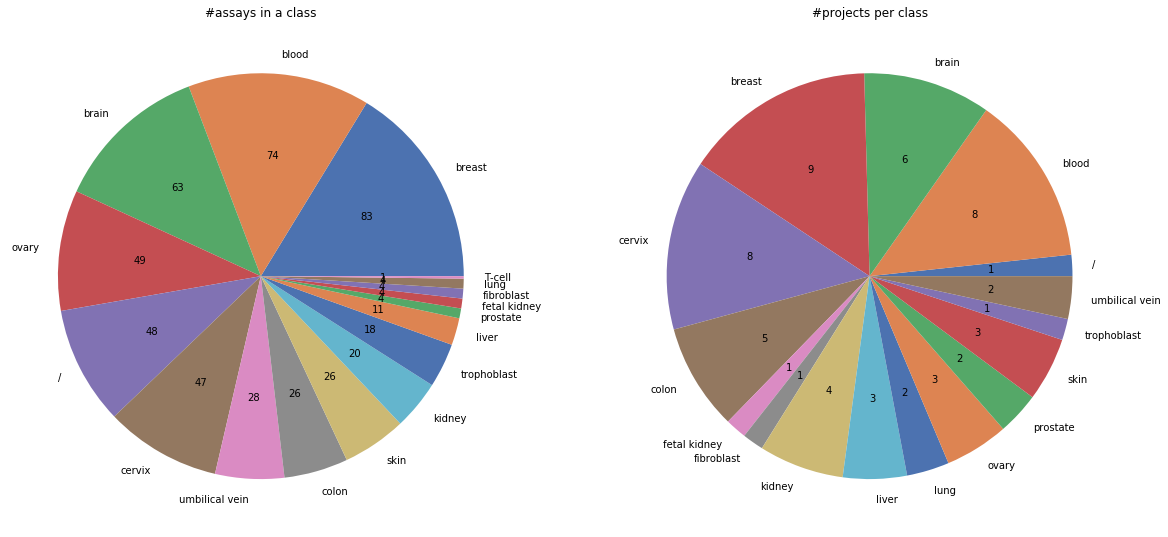

In [149]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("#assays in a class")
fig.set_facecolor('white')
_ = plt.pie(labels.value_counts().values, labels = labels.value_counts().index.values, colors = sns.color_palette("deep", n_colors=len(labels.value_counts().values)), 
autopct= lambda p: '{:.0f}'.format(p*total/100))

plt.subplot(122)
pxd_classes = metadata.groupby('tissue_type').nunique().PXD_accession
plt.title(r"#projects per class")
_ = plt.pie(pxd_classes.values, labels = pxd_classes.index.values, colors = sns.color_palette("deep", n_colors=len(labels.value_counts().values)),
autopct = lambda p: '{:.0f}'.format(p*sum(pxd_classes.values)/100))

In [132]:
pxd_classes.values

array([1, 8, 6, 9, 8, 5, 1, 1, 4, 3, 2, 3, 2, 3, 1, 2])

In [131]:
pxd_classes.index.values

array(['/', 'blood', 'brain', 'breast', 'cervix', 'colon', 'fetal kidney',
       'fibroblast', 'kidney', 'liver', 'lung', 'ovary', 'prostate',
       'skin', 'trophoblast', 'umbilical vein'], dtype=object)

---

In [123]:
full_df = pd.concat([data, labels], axis = 1)
full_df = full_df[~full_df.tissue_type.isin(["trophoblast","prostate", "fetal kidney", "lung", "fibroblast", "/"])]
full_df.loc[full_df.tissue_type == "T-cell", ["tissue_type"]] = "blood"
labels = full_df.pop("tissue_type")
data = full_df

In [103]:
weights = {}
all = labels.value_counts().sum()
for index, row in labels.value_counts().reset_index().iterrows():
    weights[row["index"]] = (all-row["tissue_type"])/row["tissue_type"]
weights

{'breast': 4.373493975903615,
 'blood': 4.946666666666666,
 'brain': 6.079365079365079,
 'ovary': 8.10204081632653,
 'cervix': 8.48936170212766,
 'umbilical vein': 14.928571428571429,
 'colon': 16.153846153846153,
 'skin': 16.153846153846153,
 'kidney': 21.3,
 'trophoblast': 23.77777777777778,
 'liver': 39.54545454545455}

In [35]:
# Models to be used:

lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
models = (lr, svc, rf, xgb)

# Parameter grids

lr_grid = {"penalty" : ['l2'],
            "class_weight": ["balanced"],
            "C": np.linspace(0.005, 5, 5)}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.005, 5, 5),
            "class_weight": [weights]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["gini", "entropy"], 
            "class_weight": [weights]}

ada_grid = {'n_estimators': np.linspace(10, 150, 4, dtype = int),
            'base_estimator': [DecisionTreeClassifier(max_depth=3, class_weight=weights)],
            "learning_rate": np.linspace(0.005, 5, 5)}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

grids = (lr_grid, svc_grid, rf_grid, xgb_grid)

In [36]:
# Outerloop loops 10 times doing 9:1 train test split
skf = StratifiedKFold(10) 
best_parameters = {}
model_names = ["lr","svc", "rf", "xgb"]
cms = {}
f1_scores = {}
all_results_df = pd.DataFrame()

In [18]:
list(weights.keys())

['breast',
 'blood',
 'brain',
 'ovary',
 'cervix',
 'umbilical vein',
 'colon',
 'skin',
 'kidney',
 'trophoblast',
 'liver']

In [37]:
# Outerloop loops 10 times doing 9:1 train test split
skf = StratifiedKFold(10) 
flag = True

for i in range(0,5):
    
    model_name = model_names[i]
    
    clf = models[i]
    grid = grids[i]

    outerloop_count = 0
    print(f"Start evaluation {model_name}")
    for train, test in skf.split(data, labels):
        
        outerloop_count += 1
        print(f"CV: {outerloop_count}/10")

        X_train = data.iloc[train,:]
        Y_train = labels.iloc[train]
        X_test = data.iloc[test,:]
        Y_test = labels.iloc[test]
        
        # Gridsearch
        gridsearch = GridSearchCV(clf, param_grid = grid, scoring = 'f1_weighted', cv = 5)
        gridsearch.fit(X_train, Y_train)
        
        Y_pred = gridsearch.predict(X_test)
        
        # Store confusion matrix and f1-score after each outerloop
        f1_score_ = f1_score(Y_test, Y_pred, average = None, labels = list(weights.keys()))

        cm = confusion_matrix(Y_test, Y_pred, labels = gridsearch.classes_)
 
        best_parameters[outerloop_count] = [gridsearch.best_params_]
        f1_scores[outerloop_count] = [f1_score_]
        cms[outerloop_count] = [cm]

    parameter_df = pd.DataFrame(best_parameters)
    f1_scores_df = pd.DataFrame(f1_scores)
    cms_df = pd.DataFrame(cms)

    model_results_df = pd.concat([parameter_df.rename({0:"parameter"}), f1_scores_df.rename({0:"f1"}), cms_df.rename({0:"cms"})]).transpose().rename(index = {x: model_name for x in range(11)})
    all_results_df = pd.concat([model_results_df, all_results_df], axis = 0)
    
    all_results_df.to_csv("base_results.csv",sep = ";", index = True)



Start evaluation lr
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation svc
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation rf
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation xgb
CV: 1/10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/xgboost/sklearn.py", line 1358, in fit
    f"In

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10], got ['blood' 'brain' 'breast' 'cervix' 'colon' 'kidney' 'liver' 'ovary' 'skin'
 'trophoblast' 'umbilical vein']

In [31]:
test = pd.concat([parameter_df.rename({0:"parameter"}), f1_scores_df.rename({0:"f1"}), cms_df.rename({0:"cms"})]).transpose().rename(index = {x: "lr" for x in range(11)})

---

# Trying different evaluation technique: drop complete project

In [98]:
import random

def train_test_project_split(dataset: pd.DataFrame, metadata: pd.DataFrame):
    
    print(metadata.tissue_type.value_counts())
    pxds = metadata.PXD_accession.unique()
    n_samples = len(dataset)
    random.shuffle(pxds)
    
    indeces = []
    for pxd in pxds:

        pxd_indeces = metadata.loc[metadata.PXD_accession == pxd,:].index.tolist() + indeces
        counter =  metadata.iloc[~metadata.index.isin(pxd_indeces),:].groupby("tissue_type").nunique()
        assays = len(pxd_indeces)

        condition1 = (assays/n_samples) < 0.1 # Ensure no more than 10% of data in testset
        condition2 = not False in (counter.PXD_accession > 1).unique() # Ensure at least 2 projects per class
        condition3 = not False in (counter.assay_id > 10).unique() # Ensure > 10 samples per class for cv

        print(f'''condition 1: {condition1}, {assays} {n_samples}
        condition 2: {condition2}, {(counter.PXD_accession > 1)}
        condition 3: {condition3}, {(counter.assay_id > 10).unique()}''')
        if condition1 and condition2 and condition3:
            print("passed conditional")
            indeces = pxd_indeces

    train = dataset.iloc[~dataset.index.isin(indeces), :]
    test = dataset.iloc[dataset.index.isin(indeces),:]

    return train, test

In [115]:
metadata = metadata.iloc[metadata.index.isin(data.index),:]

In [118]:
train_, test_ = train_test_project_split(data, metadata)

condition 1: True, 3 446
        condition 2: False, tissue_type
blood              True
brain              True
breast             True
cervix             True
colon              True
kidney             True
liver              True
ovary              True
skin               True
trophoblast       False
umbilical vein     True
Name: PXD_accession, dtype: bool
        condition 3: True, [ True]
condition 1: True, 1 446
        condition 2: False, tissue_type
blood              True
brain              True
breast             True
cervix             True
colon              True
kidney             True
liver              True
ovary              True
skin               True
trophoblast       False
umbilical vein     True
Name: PXD_accession, dtype: bool
        condition 3: True, [ True]
condition 1: True, 18 446
        condition 2: False, tissue_type
blood              True
brain              True
breast             True
cervix             True
colon              True
kidney             T

In [121]:
metadata.groupby("tissue_type").nunique()

,assay_id,tissue_type,PXD_accession
tissue_type,,,
blood,75,1,8
brain,63,1,6
breast,83,1,9
cervix,47,1,8
colon,26,1,5
kidney,20,1,4
liver,11,1,3
ovary,49,1,3
skin,26,1,3


In [58]:
metadata

NameError: name 'metadata' is not defined

In [57]:
pf, fp = train_test_project_split(data, labels)

AttributeError: 'Series' object has no attribute 'PXD_accession'

In [56]:
labels.value_counts()

breast            83
blood             75
brain             63
ovary             49
cervix            47
umbilical vein    28
colon             26
skin              26
kidney            20
trophoblast       18
liver             11
Name: tissue_type, dtype: int64

In [ ]:
skf = StratifiedKFold(10)
cms = []
count = 0
for train, test in skf.split(data, labels):
    #print(f"TRAIN:\n{labels.iloc[train].value_counts()}\n")
    #print(f"TEST:\n{labels.iloc[test].value_counts()}\n")
    
    
    X_train = data.iloc[train,:]
    Y_train = labels.iloc[train]
    X_test = data.iloc[test,:]
    Y_test = labels.iloc[test]
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred, labels = clf.classes_)
    cms.append(cm)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf2.classes_)
    #fig, ax = plt.subplots(figsize=(10,10))
    #disp.plot(ax = ax)

    count += 1

disp = ConfusionMatrixDisplay(confusion_matrix=sum(cms) / count,display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax = ax)